<a href="https://colab.research.google.com/github/anupsen00/Predicting-Price-Hike-with-Sources-using-Different-Machine-Learning-Algorithms/blob/main/GBRT_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GBRT

Mean Squared Error: 0.0001498074220291883
R^2 Score: 0.9965928395639867
Precision: 0.9944903581267218
Recall: 0.9863387978142076
F1 Score: 0.99039780521262
Accuracy: 0.9904371584699454


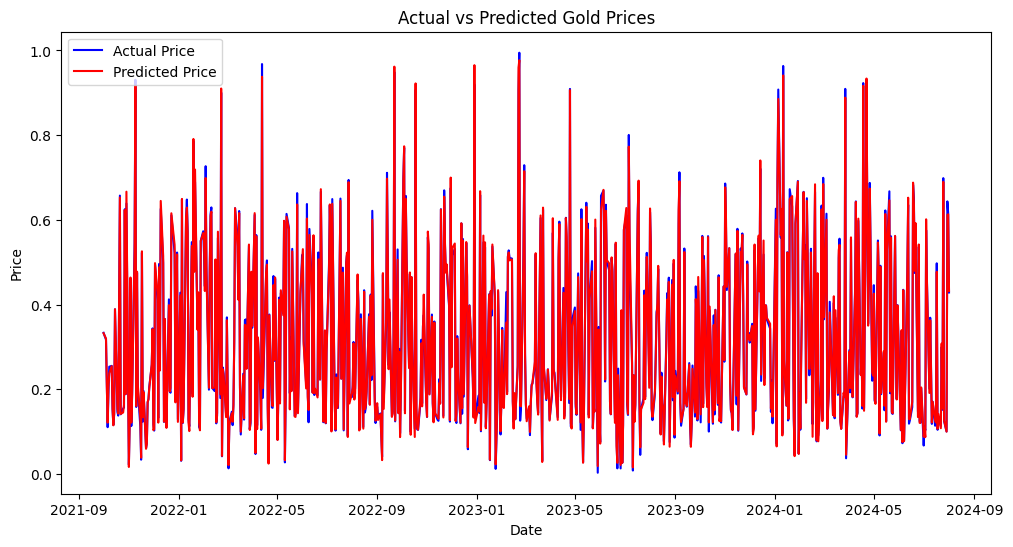

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler-
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Load the dataset
file_path = '/content/Gold Futures Historical Data (2).csv'
data = pd.read_csv(file_path)

# Data Preprocessing
def convert_volume(value):
    if isinstance(value, str):
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1000000
        else:
            return float(value.replace(',', ''))
    return value  # If it's already a float

# Apply the conversion function to the 'Vol.' column
data['Vol.'] = data['Vol.'].apply(convert_volume)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Convert other columns to numeric
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].astype(str).str.replace(',', '', regex=False)
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle the 'Change %' column
data['Change %'] = data['Change %'].astype(str).str.strip().str.replace('%', '', regex=False)
data['Change %'] = pd.to_numeric(data['Change %'], errors='coerce')

# Check and handle missing values for each column
for col in data.columns:
    if data[col].isnull().sum() > 0:
        if col == 'Vol.':  # Fill 'Vol.' with median
            data[col].fillna(data[col].median(), inplace=True)
        elif col in ['Price', 'Open', 'High', 'Low']:  # Numeric columns with iterative imputation
            imputer = IterativeImputer()
            data[[col]] = imputer.fit_transform(data[[col]])
        elif col == 'Change %':  # Choose an appropriate fill strategy for 'Change %'
            data[col].fillna(data[col].mean(), inplace=True)  # Here using mean as an example
        else:
            data.dropna(subset=[col], inplace=True)  # Drop rows with missing data in non-essential columns

# Drop rows with any remaining missing values (e.g., in 'Date' or other non-numeric columns)
data.dropna(inplace=True)

# Sort by date
data.sort_values(by='Date', inplace=True)

# Feature Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Price', 'Open', 'High', 'Low', 'Vol.']])

# Create features and labels
X = []
y = []

window_size = 60

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i].flatten())  # Flatten the window for GBRT input
    y.append(scaled_data[i, 0])  # Predicting 'Price' column

X = np.array(X)
y = np.array(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build GBRT model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Convert regression output to binary classification based on a threshold
price_threshold = np.median(y_test)  # Threshold could be median or any chosen value
y_test_binary = (y_test > price_threshold).astype(int)
y_pred_binary = (y_pred > price_threshold).astype(int)

# Calculate classification metrics
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)
accuracy = accuracy_score(y_test_binary, y_pred_binary)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][-len(y_test):], y_test, color='blue', label='Actual Price')
plt.plot(data['Date'][-len(y_pred):], y_pred, color='red', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Gold Prices')
plt.legend()
plt.show()


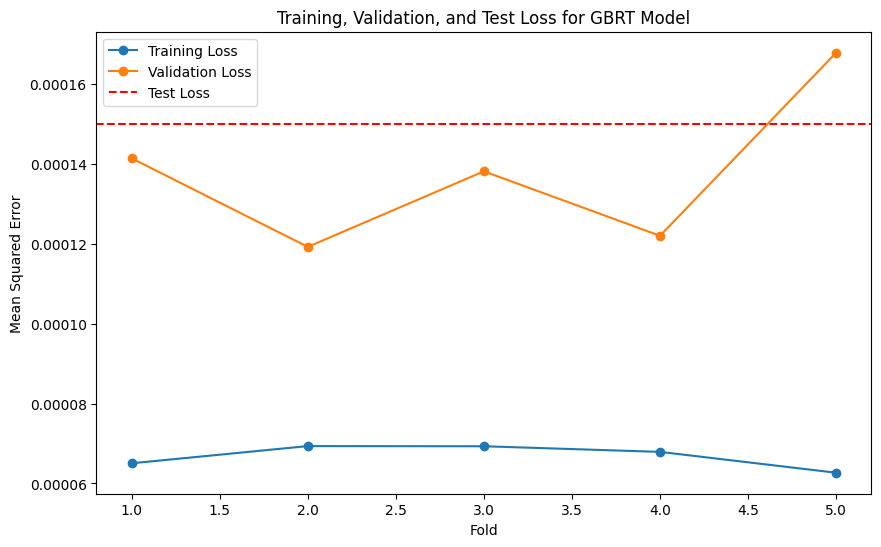

Test Loss (Mean Squared Error): 0.0001498074220291883


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Assuming X_train, y_train, X_test, y_test, and model have already been defined

# Cross-validation setup for monitoring training and validation loss
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_errors = []
val_errors = []

for train_index, val_index in kf.split(X_train):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]

    model.fit(X_tr, y_tr)

    train_pred = model.predict(X_tr)
    val_pred = model.predict(X_val)

    train_error = mean_squared_error(y_tr, train_pred)
    val_error = mean_squared_error(y_val, val_pred)

    train_errors.append(train_error)
    val_errors.append(val_error)

# Calculate the test loss
model.fit(X_train, y_train)
test_pred = model.predict(X_test)
test_error = mean_squared_error(y_test, test_pred)

# Plot Training, Validation, and Test Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_errors) + 1), train_errors, label='Training Loss', marker='o')
plt.plot(range(1, len(val_errors) + 1), val_errors, label='Validation Loss', marker='o')
plt.axhline(y=test_error, color='red', linestyle='--', label='Test Loss')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Training, Validation, and Test Loss for GBRT Model')
plt.legend()
plt.show()

# Display Test Loss
print(f"Test Loss (Mean Squared Error): {test_error}")


Yes, the plot you provided looks good! It clearly shows the Training Loss, Validation Loss, and Test Loss for the Gradient Boosting Regression Trees (GBRT) model.

Training Loss (blue line): Indicates how well the model fits the training data.

Validation Loss (orange line): Indicates how well the model performs on unseen validation data. It's typical for the validation loss to be slightly higher than the training loss.

Test Loss (red dashed line): Indicates the model's performance on the final test set.

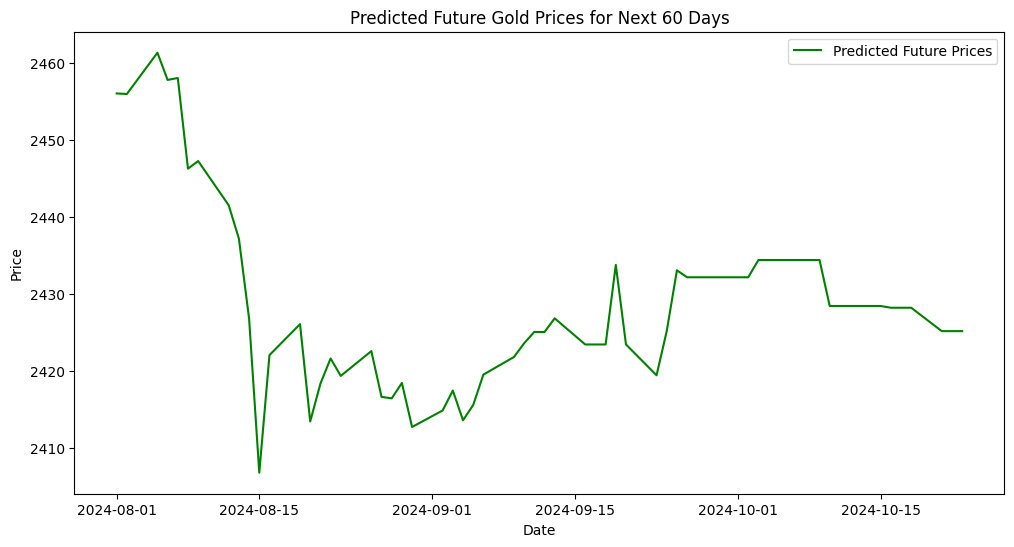

In [ ]:
# Predict future 60 days
future_predictions = []
last_window = scaled_data[-window_size:]  # Start with the last available window

for _ in range(60):  # Predict next 60 days
    next_pred = model.predict(last_window.flatten().reshape(1, -1))[0]
    future_predictions.append(next_pred)

    # Update the window: remove the first element and add the new prediction
    last_window = np.vstack([last_window[1:], np.hstack([next_pred, last_window[-1, 1:]])])

# Convert predictions to an array and create a dummy array for inverse scaling
future_predictions = np.array(future_predictions)
dummy_array = np.zeros((60, scaled_data.shape[1]))  # Shape (60, 5)
dummy_array[:, 0] = future_predictions  # Place the predictions in the 'Price' column

# Inverse transform the predictions back to the original scale
inverse_transformed_predictions = scaler.inverse_transform(dummy_array)[:, 0]  # Only take the 'Price' column

# Generate future dates
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(last_date, periods=60, freq='B')  # 'B' for business days

# Plot the future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, inverse_transformed_predictions, color='green', label='Predicted Future Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted Future Gold Prices for Next 60 Days')
plt.legend()
plt.show()


Mean Squared Error: 0.0001498074220291883
R^2 Score: 0.9965928395639867
Precision: 0.9944903581267218
Recall: 0.9863387978142076
F1 Score: 0.99039780521262
Accuracy: 0.9904371584699454


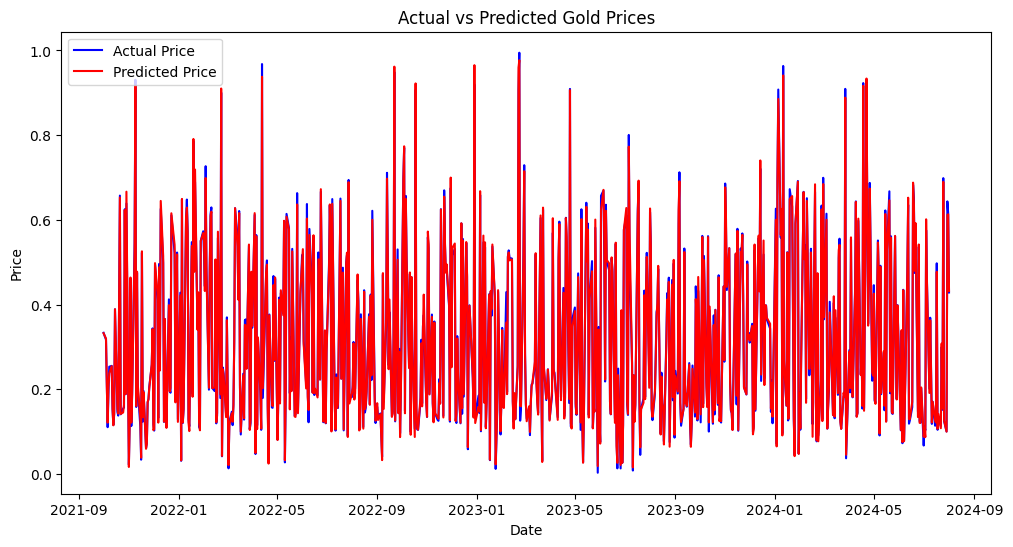

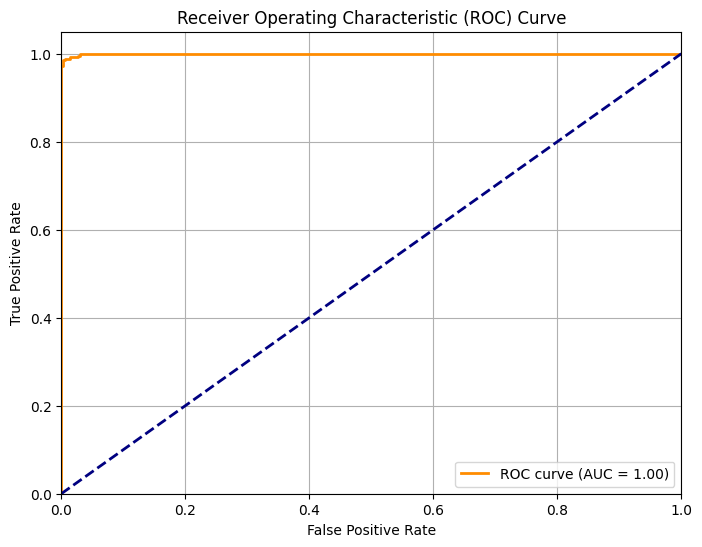

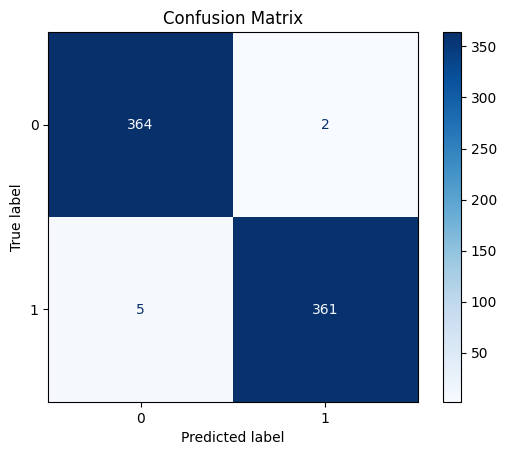

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingRegressor


# Load the dataset
file_path = '/content/Gold Futures Historical Data (2).csv'
data = pd.read_csv(file_path)

# Data Preprocessing
def convert_volume(value):
    if isinstance(value, str):
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1000000
        else:
            return float(value.replace(',', ''))
    return value  # If it's already a float

# Apply the conversion function to the 'Vol.' column
data['Vol.'] = data['Vol.'].apply(convert_volume)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Convert other columns to numeric
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].astype(str).str.replace(',', '', regex=False)
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle the 'Change %' column
data['Change %'] = data['Change %'].astype(str).str.strip().str.replace('%', '', regex=False)
data['Change %'] = pd.to_numeric(data['Change %'], errors='coerce')

# Check and handle missing values for each column
for col in data.columns:
    if data[col].isnull().sum() > 0:
        if col == 'Vol.':  # Fill 'Vol.' with median
            data[col].fillna(data[col].median(), inplace=True)
        elif col in ['Price', 'Open', 'High', 'Low']:  # Numeric columns with iterative imputation
            imputer = IterativeImputer()
            data[[col]] = imputer.fit_transform(data[[col]])
        elif col == 'Change %':  # Choose an appropriate fill strategy for 'Change %'
            data[col].fillna(data[col].mean(), inplace=True)  # Here using mean as an example
        else:
            data.dropna(subset=[col], inplace=True)  # Drop rows with missing data in non-essential columns

# Drop rows with any remaining missing values (e.g., in 'Date' or other non-numeric columns)
data.dropna(inplace=True)

# Sort by date
data.sort_values(by='Date', inplace=True)

# Feature Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Price', 'Open', 'High', 'Low', 'Vol.']])
# Create features and labels
X = []
y = []

window_size = 60

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i].flatten())  # Flatten the window for GBRT input
    y.append(scaled_data[i, 0])  # Predicting 'Price' column

X = np.array(X)
y = np.array(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build GBRT model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Convert regression output to binary classification based on a threshold
price_threshold = np.median(y_test)  # Adjust threshold as needed
y_test_binary = (y_test > price_threshold).astype(int)
y_pred_binary = (y_pred > price_threshold).astype(int)

# Calculate classification metrics
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)
accuracy = accuracy_score(y_test_binary, y_pred_binary)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][-len(y_test):], y_test, color='blue', label='Actual Price')
plt.plot(data['Date'][-len(y_pred):], y_pred, color='red', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Gold Prices')
plt.legend()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()
